<a href="https://colab.research.google.com/github/PouriaRouzrokh/AI-Deep-Learning-Lab-2022/blob/PR-nb-01/sessions/yolo/YOLO_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 0: Setting up the working directory
We start our work by installing some required libraries (including YOLOv5) and cloning our DICOMs and ground truths from a GitHub repository that we have made before. In this notebook, we will train our model on 3500 DICOMs from the CQ500 dataset. Feel free to download the entire dataset and train stronger models on it after this workshop!

In [13]:
import shutil
# Building the folders needed for data splitting
# These folders will be added to our working directory.
import os 
train_imgs_dir = 'model_data_cropped/images/train'
train_labels_dir = 'model_data_cropped/labels/train'
valid_imgs_dir = 'model_data_cropped/images/valid'
valid_labels_dir = 'model_data_cropped/labels/valid'
test_imgs_dir = 'model_data_cropped/images/test'
test_labels_dir = 'model_data_cropped/labels/test'

os.makedirs(train_imgs_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(valid_imgs_dir, exist_ok=True)
os.makedirs(valid_labels_dir, exist_ok=True)
os.makedirs(test_imgs_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)


Here we create three lists based on our dataframe: 

*   X: A list of all SOPInstanceUIDs we got from all rows (don't forget that each DICOM has a unique SOPInstanceUID, so this list includes all our DICOM names).
*   Y: A list of all labels (or the types of hemorrhage lesions) for all rows.
*   groups: A list of all StudyInstanceUIDs.

What we need to do, is to split our X into 2 different folds (80% training and 20% validation), while controlling for the group variable (so that all rows for one specific StudyInstaceUID tag go to either training or validation sets) and also stratifying our data based on the labels (so that the distribution of different labels between training and validation sets be as close as possible to our 80-20 split).

In [14]:
# Splitting the data into training and validation sets.
#from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
import pandas as pd 

csv_dir = '/media/xintie/DATA/siim-covid19-detection/csv/'
labels_df = pd.read_csv(csv_dir+'train_lung_bbox.csv')

# To make the cell work prperly if run multiple times. 
train_df, test_df = train_test_split(labels_df, test_size=0.0001, random_state=716)

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=716)



In [15]:
# Moving the images to their folders in the "model_data" directory
import shutil
png_type = 'png_cropped'

image_dir = '/media/xintie/DATA/siim-covid19-detection/'
image_folder = image_dir + '{}/train/'.format(png_type)

YOLO needs us two TXT files including the paths to images in our training and validation directories as well, so let's create those files:

In [16]:
# To make the cell work prperly if run multiple times. 
shutil.rmtree('model_data_cropped/train.txt', ignore_errors=True)
shutil.rmtree('model_data_cropped/val.txt', ignore_errors=True)
shutil.rmtree('model_data_cropped/test.txt', ignore_errors=True)

# Building the txt files including paths to all images in training and validation sets

with open('model_data_cropped/train.txt', 'w') as f:
    for file in os.listdir(train_imgs_dir):
        f.write(os.path.join(train_imgs_dir, file)+'\n')
            
with open('model_data_cropped/val.txt', 'w') as f:
    for file in os.listdir(valid_imgs_dir):
        f.write(os.path.join(valid_imgs_dir, file)+'\n')
        
with open('model_data_cropped/test.txt', 'w') as f:
    for file in os.listdir(test_imgs_dir):
        f.write(os.path.join(test_imgs_dir, file)+'\n')
        

OK, now we should create the labels for training our YOLO model.
YOLO needs a TXT file for each image that contains the locations of each bounding box in that image, plus the index for the class of that box in separate lines. 

We will create these files below. For doing this, we first give a unique index to each class of brain hemorrhage in our dataset and then write their location in files. Here is where we will need your coding again:

YOLO needs four coordinates for each box:

*  x_min: The x-coordinate for the upper-left corner of the box in pixels.
*  y_min: The y-coordinate for the upper-left corner of the box in pixels.
*  width: The wideness of the box in pixels.
*  height: The height of the box in pixels.

We should note that the way YOLO receives ground truth labels from us (and further predicts labels) is special. YOLO needs all the above numbers proportional to the size of the image, (and not in their absolute values). For example, if the image size is 512 * 512 (as in our case), and the x-min for an imaginary box is 100, YOLO expects a float number (100/512) as the x-min in our labels. This rule also applies to all other bounding box numbers YOLO needs.

In [17]:
def Convert_bbox_toYOLO(bbox, image_size):
  """
  Receive the coordinates for a given bbox and convert its coordinates to the 
  YOLO format.
  
  inputs:
    - bbox (dict): a dictionary with the following keys: 
    (all have absolute values.)
      -- 'x': the x coordinate for the top left point of the bounding box.
      -- 'y': the y coordinate for the top left point of the bounding box.
      -- 'width': the width of the bounding box.
      -- 'height': the height of the bounding box.
   
    - image_size (int): the shape of the image is (image_size, image_size)
  
  outputs:
    - yolo_bbox (dict): a dictionary with the following keys:
    (all have values scaled between 0 - 1 based on the image_size.)
      -- 'x_center': the x coordinate for the center of the bounding box.
      -- 'y_center': the y coordinate for the center of the bounding box.
      -- 'width': the width of the bounding box.
      -- 'height': the height of the bounding box.
  """

  yolo_bbox = dict()

  ##### START YOUR CODE HERE (4 lines of code):

  yolo_bbox['x_center'] = (bbox['x'] + bbox['width'] / 2) / image_size
  yolo_bbox['y_center'] = (bbox['y'] + bbox['height'] / 2) / image_size
  yolo_bbox['width'] = bbox['width'] / image_size
  yolo_bbox['height'] = bbox['height'] / image_size
  
  ##### END YOUR CODE HERE.

  return yolo_bbox

In [18]:
# To make the cell work prperly if run multiple times. 
shutil.rmtree(train_labels_dir, ignore_errors=True) 
os.makedirs(train_labels_dir, exist_ok=True)
shutil.rmtree(valid_labels_dir, ignore_errors=True)
os.makedirs(valid_labels_dir, exist_ok=True)
shutil.rmtree(test_labels_dir, ignore_errors=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Creating the labels

label_to_index_dict = {
    'COVID': 0
}

In [19]:
from tqdm import * 

def Get_GT_from_txt(txtpath):
    with open(txtpath) as f:
        lines = f.readlines()
        array = []
        for line in lines: 
            array.append([x for x in line.split()])
        return array

# Creating the TXT file for each image
# Each image will have a single TXT file including all its labels (each file 
# may have multiple lines, each for one bounding box on that image).

label_folder = image_dir + 'label_file_{}/'.format(png_type)
Dsize = 512 

id_name_list = train_df.id.tolist() 
# specify your image path
for id_name in tqdm(id_name_list):
    bboxes = Get_GT_from_txt(label_folder + id_name + '.txt')
    label_file = 'model_data_cropped/labels/train/' + id_name + '.txt'
    with open(label_file, "w+") as f:
        for bbox in bboxes:
            bbox[1] = float(bbox[1]) / Dsize
            bbox[3] = float(bbox[3]) / Dsize
            bbox[2] = float(bbox[2]) / Dsize
            bbox[4] = float(bbox[4]) / Dsize
            f.write(" ".join([str(i) for i in [0, bbox[1],bbox[2],bbox[3],bbox[4]]])+'\n')

id_name_list = val_df.id.tolist() 
# specify your image path
for id_name in tqdm(id_name_list):
    bboxes = Get_GT_from_txt(label_folder + id_name + '.txt')
    label_file = 'model_data_cropped/labels/valid/' + id_name + '.txt'
    with open(label_file, "w+") as f:
        for bbox in bboxes:
            bbox[1] = float(bbox[1]) / Dsize
            bbox[3] = float(bbox[3]) / Dsize
            bbox[2] = float(bbox[2]) / Dsize
            bbox[4] = float(bbox[4]) / Dsize
            f.write(" ".join([str(i) for i in [0, bbox[1],bbox[2],bbox[3],bbox[4]]])+'\n')

id_name_list = test_df.id.tolist() 
# specify your image path
for id_name in tqdm(id_name_list):
    bboxes = Get_GT_from_txt(label_folder + id_name + '.txt')
    label_file = 'model_data_cropped/labels/test/' + id_name + '.txt'
    with open(label_file, "w+") as f:
        for bbox in bboxes:
            bbox[1] = float(bbox[1]) / Dsize
            bbox[3] = float(bbox[3]) / Dsize
            bbox[2] = float(bbox[2]) / Dsize
            bbox[4] = float(bbox[4]) / Dsize
            f.write(" ".join([str(i) for i in [0, bbox[1],bbox[2],bbox[3],bbox[4]]])+'\n')

100%|██████████| 1/1 [00:00<00:00, 1481.04it/s]


### Part 4: Configuring the YOLOv5 Model
Alright, now that we have all the images and labels set up, we can configure the YOLOv5 model for our training. For doing so, we need to change the YAML file in the model directory. We should give it the path to our training and validation directories of images, the number of classes, and the name of classes.

In [20]:
# Configuring the data.yaml file

import yaml
model_dir = 'yolov5'

data = dict(
    train = '../model_data_cropped/images/train',
    val = '../model_data_cropped/images/valid',   
    nc    = 1, # number of classes
    names = list(label_to_index_dict.keys()) # classes
    )

with open(f'{model_dir}/data/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

with open(f'{model_dir}/data/data.yaml', 'r') as file:
    for line in file.readlines():
        print(line.strip())

names:
- COVID
nc: 1
train: ../model_data_cropped/images/train
val: ../model_data_cropped/images/valid


### Part 5: View and modify the hyperparameters (optional)
The Ultralytics implementation of YOLO gives us the ability to change many of the hyperparameters YOLO works with. These are all accessible in a YAML file in the model's directory. We will not touch these settings for now, but let's visualize them before we proceed:

In [21]:
with open(f'{model_dir}/data/hyps/hyp.scratch-high.yaml', 'r') as file:
    for line in file.readlines():
        print(line.strip())

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for high-augmentation COCO training from scratch
# python train.py --batch 32 --cfg yolov5m6.yaml --weights '' --data coco.yaml --img 1280 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.3  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 0.7  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # foc

### Part 6: Training
Perfect, now everything is set for us to start the training! Fortunately, the training itself could be run using one line of code! We just need to determine the image size, batch size, number of epochs, the directory to our model's directory, a name for our project, and a name for our current run of experiment. 

Please note that the training command should be run from the command line, that is why we have put an "!" mark before the line we do the training.

**Note: In Google Colab, we cannot run the training with a batch size greater than 8, otherwise we will hit the memory limits. Training with such a small batch size on the other hand may take a lot of time, so we only train our model for one epoch. Please run this notebook locally or give it more time later for a full training.**

# Inference stage 

As the training will probably take longer than the time we have available in this workshop, we will work with a pre-trained model from now on. We have already trained this model using almost the same configuration we set earlier.You can download that model and replace it in a usual place in our working directory by running the following cell:

All right, now we assume that we have done a full training. The Ultralytics implementation of YOLOv5 plots a lot of useful curves and logs much information during the training. You could easily visualize that inforation by looking at your model_dir/project/run directory or even using loggers like TensorBoard or WandB.

In [22]:
# Visualizing the training performance
import matplotlib.pylab as plt

IMAGE_SIZE = 512
BATCH_SIZE = 50
EPOCHS = 100
PROJECT_dir = f'{model_dir}/COVID_pneumonia_YOLO_Project'

def Show_performance(run_name:str, project_dir:str=PROJECT_dir):
    
    run_path = os.path.join(project_dir, run_name)
    
    # Model's performance
    results_df = pd.read_csv(os.path.join(run_path, 'results.csv'))
    metrics = {'precision':[], 'recall':[], 'mAP.05':[]}
    for i, row in results_df.iterrows():
        for metric, key in zip(['precision', 'recall', 'mAP.05'], ['   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5']):
            metrics[metric].append(row[key])   
    max_precision = max(metrics['precision'])
    max_recall = max(metrics['recall'])
    max_mAP = max(metrics['mAP.05'])
    print(f"Best precision: Epoch {metrics['precision'].index(max_precision)} -> {max_precision}")
    print(f"Best recall: Epoch {metrics['recall'].index(max_recall)} -> {max_recall}")
    print(f"Best mAP.05: Epoch {metrics['mAP.05'].index(max_mAP)} -> {max_mAP}")
    
    # Training curves
    #print("\nDisplaying the training curves:")
    #plt.figure(figsize = (12,12))
    #plt.axis('off')
    #plt.imshow(plt.imread(os.path.join(run_path, 'results.png')));
    #plt.show()
    
    #GTs vs predictions
    print("\nDisplaying the ground truths vs predictions for three example batches from the validation set:")
    fig, axes = plt.subplots(2, 2, figsize=(15, 20))
    for i in range(1):
        axes[i, 0].imshow(plt.imread(os.path.join(run_path, f'val_batch{i}_labels.jpg')))
        axes[i, 1].imshow(plt.imread(os.path.join(run_path, f'val_batch{i}_pred.jpg')))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 0].set_title('Ground Truths')
        axes[i, 1].set_title('Predictions')

Best precision: Epoch 68 -> 0.5945
Best recall: Epoch 59 -> 0.53351
Best mAP.05: Epoch 18 -> 0.50946

Displaying the ground truths vs predictions for three example batches from the validation set:


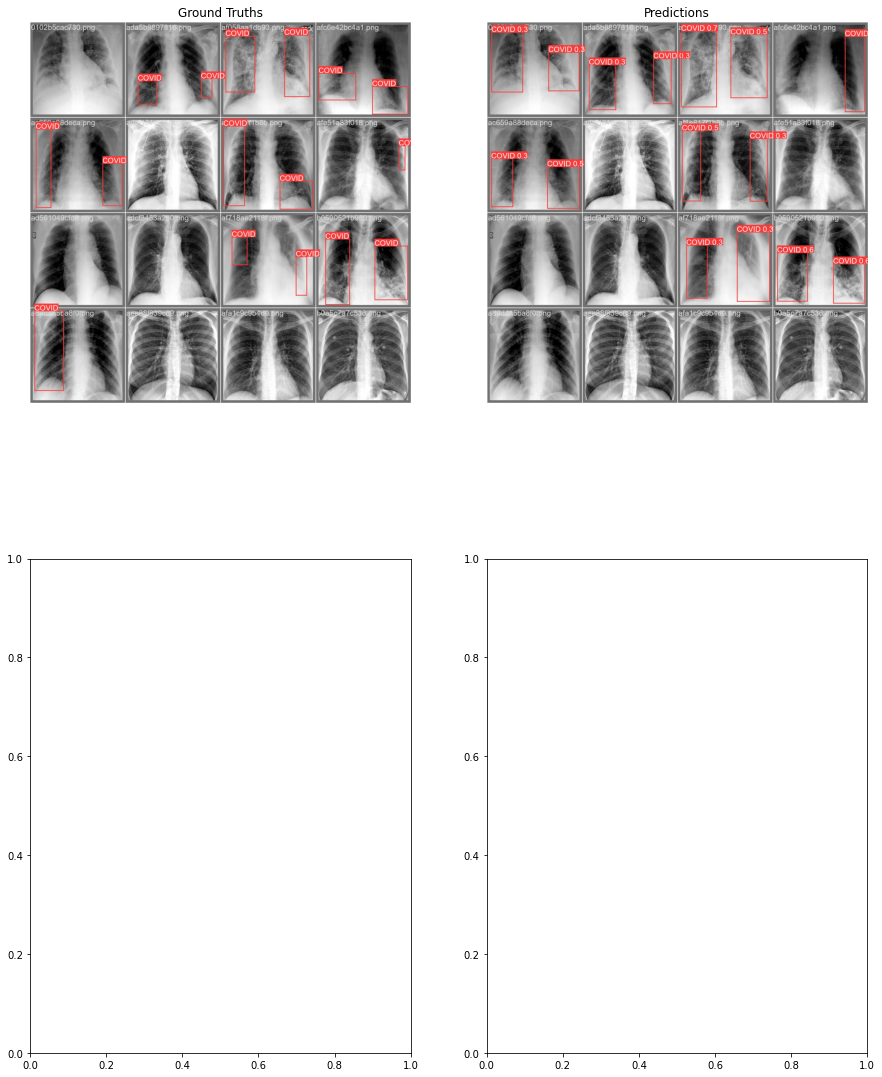

In [23]:
RUN = 'Exp_cropped_medium_pre'
Show_performance(RUN)

#Exp_cropped_large: 0.48913
#Exp_cropped_large_pre: 0.49686

#Exp_cropped_medium: 0.49893
#Exp_cropped_medium_pre: 0.50946

#Exp_cropped_small: 0.50008
#Exp_cropped_small_pre: 0.49239


**Please note that the best mAP of our model has been about 0.4. Though not very bad, this mAP is not very high. Rather than the training hyperparameters, What other factors do you think can explain this phenomenon?**

### Part 7: Inference
As the final part of our notebook, let's apply our YOLO model to a set of images. For doing this, we separate a part of images that our model had not seen during the training (Please note that these images are different than the validation images you created above, as we are now working with a model that we had trained before; not a model that you trained here). 

In [28]:
RUN = 'Exp_cropped_medium_pre'

#0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7
#Exp_cropped_large: 0.485
#Exp_cropped_large_pre: 0.494

#Exp_cropped_medium: 0.494 
#Exp_cropped_medium_pre: 0.497, 0.501, 0.506, 0.508, 0.505, 0.5, 0.491, 0.476(0.75)

#Exp_cropped_small: 0.490
#Exp_cropped_medium_pre: 0.485  

# Setting up the pipeline for inference
weights_path = f'{PROJECT_dir}/{RUN}/weights/best.pt'
destination_dir = f'{PROJECT_dir}/{RUN}/Inference_Results'
output_name = 'results'

img_size = 512
conf: float = 0.25
iou_threshold: float = 0.1
max_dt = 5
# We should now run the detect.py code from the model directory and pass all 
# the arguments that YOLO needs. 

!python {model_dir}/val.py  --weights {weights_path} \
                            --data  {model_dir}/data/data.yaml \
                               --project {destination_dir} \
                               --name {output_name}\
                               --img {img_size} \
                               --conf {conf} \
                               --iou-thres {iou_threshold} \
                               --max-det {max_dt} \
                               --save-txt \
                               #--save-conf \
                               --exist-ok\
                               --verbose

/home/xintie/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
val: data=yolov5/data/data.yaml, weights=['yolov5/COVID_pneumonia_YOLO_Project/Exp_cropped_medium_pre/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.25, iou_thres=0.1, max_det=5, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/COVID_pneumonia_YOLO_Project/Exp_cropped_medium_pre/Inference_Results, name=results, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.5 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN RTX, 24220MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
val: Scanni

In [29]:
import numpy as np 
a = [0.482, 0.486, 0.489, 0.488, 0.485, 0.477, 0.466]  # 'Exp_cropped_large'
print('mAP: {:.3f}'.format(np.mean(a)))
a = [0.499, 0.500, 0.504, 0.502, 0.494, 0.486, 0.480]  # 'Exp_cropped_large_pre'
print('mAP: {:.3f}'.format(np.mean(a)))


a = [0.494, 0.503, 0.503, 0.499, 0.494, 0.501, 0.476]  # 'Exp_cropped_medium'
print('mAP: {:.3f}'.format(np.mean(a)))
a = [0.497, 0.501, 0.506, 0.508, 0.505, 0.5, 0.491]   # 'Exp_cropped_medium_pre'
print('mAP: {:.3f}'.format(np.mean(a)))


a = [0.488, 0.488, 0.493, 0.495, 0.490, 0.482, 0.475]  # 'Exp_cropped_small'
print('mAP: {:.3f}'.format(np.mean(a)))
a = [0.480, 0.479, 0.481, 0.483, 0.485, 0.474, 0.464]  # 'Exp_cropped_small_pre'
print('mAP: {:.3f}'.format(np.mean(a)))



mAP: 0.482
mAP: 0.495
mAP: 0.496
mAP: 0.501
mAP: 0.487
mAP: 0.478


In [30]:
# We should now run the detect.py code from the model directory and pass all 
# the arguments that YOLO needs. 

inference_imgs_dir =  './model_data_cropped/images/valid'

!python {model_dir}/detect.py  --weights {weights_path} \
                               --source {inference_imgs_dir} \
                               --project {destination_dir} \
                               --name {output_name}\
                               --img {img_size} \
                               --conf {conf} \
                               --iou-thres {iou_threshold} \
                               --max-det {max_dt} \
                               --save-txt \
                               #--save-conf \
                               --exist-ok

/home/xintie/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
detect: weights=['yolov5/COVID_pneumonia_YOLO_Project/Exp_cropped_medium_pre/weights/best.pt'], source=./model_data_cropped/images/valid, data=yolov5/data/coco128.yaml, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.1, max_det=5, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/COVID_pneumonia_YOLO_Project/Exp_cropped_medium_pre/Inference_Results, name=results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.8.5 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN RTX, 24220MiB)

Fusing layers... 
Model summary: 212 layer

image 48/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/142ec2f06025.png: 512x512 (no detections), 12.5ms
image 49/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/1444611cf962.png: 512x512 1 COVID, 11.6ms
image 50/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/1498eec2b503.png: 512x512 (no detections), 12.4ms
image 51/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/16329e63780b.png: 512x512 (no detections), 11.7ms
image 52/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/16397e909369.png: 512x512 (no detections), 12.0ms
image 53/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/1643171226c2.png: 512x512 1 COVID, 12.4ms
image 54/634 /media/xintie/DATA/siim-covid19

image 100/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/29f2f88bcabe.png: 512x512 2 COVIDs, 11.5ms
image 101/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/2ab080e51a21.png: 512x512 1 COVID, 11.5ms
image 102/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/2ad6ea7e7941.png: 512x512 2 COVIDs, 11.5ms
image 103/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/2b0a6fed98fb.png: 512x512 (no detections), 11.5ms
image 104/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/2b1242514f50.png: 512x512 (no detections), 12.5ms
image 105/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/2b81c9da7d2b.png: 512x512 (no detections), 11.5ms
image 106/634 /media/xintie/DATA/siim-covid1

image 152/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/3e87fd4c0999.png: 512x512 1 COVID, 11.8ms
image 153/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/3e8932af3c6f.png: 512x512 (no detections), 11.3ms
image 154/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/3e916851115e.png: 512x512 (no detections), 11.8ms
image 155/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/3f7e9b2c2135.png: 512x512 2 COVIDs, 11.2ms
image 156/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/3f9b1542800e.png: 512x512 1 COVID, 11.8ms
image 157/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/3fee3aeb386a.png: 512x512 2 COVIDs, 11.4ms
image 158/634 /media/xintie/DATA/siim-covid19-detect

image 205/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/52c97017741a.png: 512x512 2 COVIDs, 11.4ms
image 206/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/54155a058e38.png: 512x512 2 COVIDs, 11.7ms
image 207/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/543e29e7d374.png: 512x512 (no detections), 12.2ms
image 208/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/5458c3cd03a3.png: 512x512 1 COVID, 11.6ms
image 209/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/545fb830023d.png: 512x512 2 COVIDs, 12.2ms
image 210/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/54d8b82f1ced.png: 512x512 (no detections), 13.3ms
image 211/634 /media/xintie/DATA/siim-covid19-detec

image 257/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/6e9fad584bff.png: 512x512 2 COVIDs, 13.9ms
image 258/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/6ea6f1a79e68.png: 512x512 2 COVIDs, 11.7ms
image 259/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/6ea732c63929.png: 512x512 2 COVIDs, 12.4ms
image 260/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/6ef10f0b23d5.png: 512x512 2 COVIDs, 11.8ms
image 261/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/6f433de37ffc.png: 512x512 (no detections), 11.5ms
image 262/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/6f815bf5bac5.png: 512x512 1 COVID, 11.6ms
image 263/634 /media/xintie/DATA/siim-covid19-detection/yo

image 311/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/85ffddb247ad.png: 512x512 2 COVIDs, 11.5ms
image 312/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/8600e434d5f4.png: 512x512 1 COVID, 12.2ms
image 313/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/86c22fdbdf51.png: 512x512 (no detections), 11.7ms
image 314/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/87717257302c.png: 512x512 (no detections), 12.0ms
image 315/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/8788b97939b6.png: 512x512 2 COVIDs, 11.8ms
image 316/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/8798f704cce8.png: 512x512 1 COVID, 11.5ms
image 317/634 /media/xintie/DATA/siim-covid19-detect

image 364/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/99ba4aecc0ab.png: 512x512 (no detections), 11.8ms
image 365/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/99e8d942f5b8.png: 512x512 2 COVIDs, 11.7ms
image 366/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/9a344cc0f907.png: 512x512 (no detections), 11.7ms
image 367/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/9a921b34dbc6.png: 512x512 1 COVID, 11.6ms
image 368/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/9aa0a71a5c19.png: 512x512 (no detections), 12.1ms
image 369/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/9ae7751f111a.png: 512x512 1 COVID, 11.9ms
image 370/634 /media/xintie/DATA/siim-covid19

image 416/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ab37848b342f.png: 512x512 1 COVID, 12.2ms
image 417/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ab55abb953d1.png: 512x512 1 COVID, 11.5ms
image 418/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ac212043ee3c.png: 512x512 2 COVIDs, 11.6ms
image 419/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ac659a88deca.png: 512x512 2 COVIDs, 11.2ms
image 420/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ad561049cfd8.png: 512x512 (no detections), 11.5ms
image 421/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ad8d4a5ba8f0.png: 512x512 (no detections), 11.2ms
image 422/634 /media/xintie/DATA/siim-covid19-detect

image 468/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/be68bf7d1885.png: 512x512 2 COVIDs, 13.2ms
image 469/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/be68c5758c13.png: 512x512 2 COVIDs, 11.7ms
image 470/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/beba206be689.png: 512x512 (no detections), 12.4ms
image 471/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/bf0c71616088.png: 512x512 (no detections), 11.3ms
image 472/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/bf91bd24437a.png: 512x512 2 COVIDs, 13.1ms
image 473/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/bfe716103787.png: 512x512 (no detections), 12.3ms
image 474/634 /media/xintie/DATA/siim-covid

image 521/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/d19ed8d811ad.png: 512x512 1 COVID, 13.4ms
image 522/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/d1ad910a2738.png: 512x512 1 COVID, 12.0ms
image 523/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/d220b3a6c538.png: 512x512 (no detections), 12.4ms
image 524/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/d234d34f4774.png: 512x512 2 COVIDs, 11.5ms
image 525/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/d250cb25dd00.png: 512x512 1 COVID, 12.3ms
image 526/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/d26eba222019.png: 512x512 (no detections), 11.9ms
image 527/634 /media/xintie/DATA/siim-covid19-detecti

image 573/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ea2117b53323.png: 512x512 2 COVIDs, 14.9ms
image 574/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ea743e2eccf9.png: 512x512 (no detections), 12.6ms
image 575/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/eb0a668ec905.png: 512x512 2 COVIDs, 15.2ms
image 576/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/eb13bcf19cff.png: 512x512 1 COVID, 12.6ms
image 577/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/eb5282ff3153.png: 512x512 1 COVID, 12.8ms
image 578/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/ebe3be9dce95.png: 512x512 (no detections), 12.8ms
image 579/634 /media/xintie/DATA/siim-covid19-detect

image 625/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/fc5bdb8896cc.png: 512x512 (no detections), 12.3ms
image 626/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/fc612cef0a2b.png: 512x512 (no detections), 12.0ms
image 627/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/fd307ea3d74b.png: 512x512 (no detections), 12.1ms
image 628/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/fd46baeed64d.png: 512x512 2 COVIDs, 11.3ms
image 629/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/fd7515610b5a.png: 512x512 (no detections), 11.5ms
image 630/634 /media/xintie/DATA/siim-covid19-detection/yolo_pneumonia_detection/model_data_cropped/images/valid/fe2008897820.png: 512x512 1 COVID, 11.4ms
image 631/634 /media/xintie/DATA/siim

Before we wrap up this notebook, we can also visualize some of the YOLO predictions!

In [1]:
from matplotlib import patches 
def Show_prediction(img_path):
  """
  A function to plot an image and show the bounding boxes predicted by YOLO for that image.
  """
  index_to_label_dict = {value: key for key, value in label_to_index_dict.items()}
  fig, ax = plt.subplots(1, 1, figsize=(7, 7))
  ax.imshow(plt.imread(img_path), cmap='gray')
  label_path = f'{destination_dir}/{output_name}/labels/{img_path.split("/")[-1][:-4]}.txt'
  if os.path.exists(label_path):  
    with open(label_path, 'r') as f:
      for i, line in enumerate(f.readlines()):
        line = [float(value) for value in line.strip().split(' ')]
        label = index_to_label_dict[int(line[0])]
        color = 'r'
        confidence = round(float(line[-1]), 2)
        x_min = (line[1] - line[3]/2) * 512
        y_min = (line[2] - line[4]/2) * 512
        width = line[3] * 512
        height = line[4] * 512 
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(5, 15+i*25, f'{label}-confidence: {confidence}', color='w', fontsize=10, bbox={'alpha':0.6,'color':color})


def Show_GT(img_path):
  """
  A function to plot an image and show the bounding boxes predicted by YOLO for that image.
  """
  index_to_label_dict = {value: key for key, value in label_to_index_dict.items()}
  fig, ax = plt.subplots(1, 1, figsize=(7, 7))
  ax.imshow(plt.imread(img_path), cmap='gray')
  label_path = f'{inference_imgs_dir}/labels/{img_path.split("/")[-1][:-4]}.txt'
  if os.path.exists(label_path):  
    with open(label_path, 'r') as f:
      for i, line in enumerate(f.readlines()):
        line = [float(value) for value in line.strip().split(' ')]
        print(line)
        label = index_to_label_dict[int(line[0])]
        color = 'r'
        confidence = round(float(line[-1]), 2)
        x_min = (line[1] - line[3]/2) * 512
        y_min = (line[2] - line[4]/2) * 512
        width = line[3] * 512
        height = line[4] * 512 
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(5, 15+i*25, f'{label}-confidence: {confidence}', color='w', fontsize=10, bbox={'alpha':0.6,'color':color})

        
# Now we build a list of all paths to images we had split for validaiton of our model
# And then feed them to the function we defined above.
# Feel free to visualize the predictions for multple images and see how the results 
# look like!
img_paths = [os.path.join(inference_imgs_dir, img) for img in os.listdir(inference_imgs_dir)]

show_index = 2
Show_prediction(img_paths[show_index])
Show_GT(img_paths[show_index])

NameError: name 'os' is not defined

That's it! Congratulations on training and applying your first YOLOv5 model. Hopefully, you have learned how to train more YOLO models on your custom datasets. In case you are interested, there are a few more things you can try with YOLOv5:

*   Changing the hyperparameters (e.g., IOU, learning rate, etc.) and retraining your model.
*   Applying test time augmentation (TTA) during your inference.
*   Exploring the different augmentations YOLO does during the training, especially the mosaic augmentation. 



**Thank you for attending this workshop!**